In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.datasets import load_digits
from sklearn import datasets
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as tt

/home/junyeobe/.local/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.13) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [2]:
class Digits(Dataset):
    """Scikit-Learn Digits dataset."""

    def __init__(self, mode='train', transforms=None):
        digits = load_digits()
        if mode == 'train':
            self.data = digits.data[:1000].astype(np.float32)
            self.targets = digits.target[:1000]
        elif mode == 'val':
            self.data = digits.data[1000:1350].astype(np.float32)
            self.targets = digits.target[1000:1350]
        else:
            self.data = digits.data[1350:].astype(np.float32)
            self.targets = digits.target[1350:]

        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample_x = self.data[idx]
        sample_y = self.targets[idx]
        if self.transforms:
            sample_x = self.transforms(sample_x)
        return (sample_x, sample_y)        

In [49]:
class EBM(nn.Module):
    def __init__(self, energy_net, alpha, sigma, ld_steps, D):
        super(EBM, self).__init__()

        print('EBM by JT.')

        # the neural net used by the EBM
        self.energy_net = energy_net

        # the loss for classification
        self.nll = nn.NLLLoss(reduction='none')  # it requires log-softmax as input!!

        # hyperparams
        self.D = D

        self.sigma = sigma

        self.alpha = torch.FloatTensor([alpha])

        self.ld_steps = ld_steps

    def classify(self, x):
        f_xy = self.energy_net(x)
        y_pred = torch.softmax(f_xy, 1)
        return torch.argmax(y_pred, dim=1)

    def class_loss(self, f_xy, y):
        # - calculate logits (for classification)
        y_pred = torch.softmax(f_xy, 1)

        return self.nll(torch.log(y_pred), y)

    def gen_loss(self, x, f_xy):
        # - sample using Langevine dynamics
        x_sample = self.sample(x=None, batch_size=x.shape[0])

        # - calculate f(x_sample)[y]
        f_x_sample_y = self.energy_net(x_sample)

        return -(torch.logsumexp(f_xy, 1) - torch.logsumexp(f_x_sample_y, 1))

    def forward(self, x, y, reduction='avg'):
        # =====
        # forward pass through the network
        # - calculate f(x)[y]
        f_xy = self.energy_net(x)

        # =====
        # discriminative part
        # - calculate the discriminative loss: the cross-entropy
        L_clf = self.class_loss(f_xy, y)

        # =====
        # generative part
        # - calculate the generative loss: E(x) - E(x_sample)
        L_gen = self.gen_loss(x, f_xy)

        # =====
        # Final objective
        if reduction == 'sum':
            loss = (L_clf + L_gen).sum()
        else:
            loss = (L_clf + L_gen).mean()

        return loss

    def energy_gradient(self, x):
        self.energy_net.eval()

        # copy original data that doesn't require grads!
        x_i = torch.FloatTensor(x.data)
        x_i.requires_grad = True  # WE MUST ADD IT, otherwise autograd won't work

        # calculate the gradient
        x_i_grad = torch.autograd.grad(torch.logsumexp(self.energy_net(x_i), 1).sum(), [x_i], retain_graph=True)[0]

        self.energy_net.train()

        return x_i_grad

    def langevine_dynamics_step(self, x_old, alpha):
        # Calculate gradient wrt x_old
        grad_energy = self.energy_gradient(x_old)
        # Sample eta ~ Normal(0, alpha)
        epsilon = torch.randn_like(grad_energy) * self.sigma

        # New sample
        x_new = x_old + alpha * grad_energy + epsilon

        return x_new

    def sample(self, batch_size=64, x=None):
        # - 1) Sample from uniform
        x_sample = 2. * torch.rand([batch_size, self.D]) - 1.

        # - 2) run Langevine Dynamics
        for i in range(self.ld_steps):
            x_sample = self.langevine_dynamics_step(x_sample, alpha=self.alpha)

        return x_sample

In [50]:
def evaluation(test_loader, name=None, model_best=None, epoch=None):
    # EVALUATION
    if model_best is None:
        # load best performing model
        model_best = torch.load(name + '.model')

    model_best.eval()
    loss = 0.
    loss_error = 0.
    loss_gen = 0.
    N = 0.
    for indx_batch, (test_batch, test_targets) in enumerate(test_loader):
        # hybrid loss
        loss_t = model_best.forward(test_batch, test_targets, reduction='sum')
        loss = loss + loss_t.item()
        # classification error
        y_pred = model_best.classify(test_batch)
        e = 1.*(y_pred == test_targets)
        loss_error = loss_error + (1. - e).sum().item()
        # generative nll
        f_xy_test = model_best.energy_net(test_batch)
        loss_gen = loss_gen + model_best.gen_loss(test_batch, f_xy_test).sum()
        # the number of examples
        N = N + test_batch.shape[0]
    loss = loss / N
    loss_error = loss_error / N
    loss_gen = loss_gen / N

    if epoch is None:
        print(f'FINAL PERFORMANCE: nll={loss}, ce={loss_error}, gen_nll={loss_gen}')
    else:
        print(f'Epoch: {epoch}, val nll={loss}, val ce={loss_error}, val gen_nll={loss_gen}')

    return loss, loss_error, loss_gen


In [51]:
def samples_real(name, test_loader):
    # REAL-------
    num_x = 4
    num_y = 4
    x, _ = next(iter(test_loader))
    x = x.detach().numpy()

    fig, ax = plt.subplots(num_x, num_y)
    for i, ax in enumerate(ax.flatten()):
        plottable_image = np.reshape(x[i], (8, 8))
        ax.imshow(plottable_image, cmap='gray')
        ax.axis('off')

    plt.savefig(name+'_real_images.pdf', bbox_inches='tight')
    plt.close()

In [52]:
def samples_generated(name, data_loader, extra_name=''):
    # GENERATIONS-------
    model_best = torch.load(name + '.model')
    model_best.eval()

    num_x = 4
    num_y = 4
    x = model_best.sample(num_x * num_y)
    x = x.detach().numpy()

    fig, ax = plt.subplots(num_x, num_y)
    for i, ax in enumerate(ax.flatten()):
        plottable_image = np.reshape(x[i], (8, 8))
        ax.imshow(plottable_image, cmap='gray')
        ax.axis('off')

    plt.savefig(name + '_generated_images' + extra_name + '.pdf', bbox_inches='tight')
    plt.close()

In [91]:
def plot_curve(name, nll_val, file_name='_nll_val_curve.pdf', color='b-'):
    plt.plot([i for i in range((len(nll_val)))], nll_val, color, linewidth='3')
    plt.xlabel('epochs')
    plt.ylabel('nll')
    plt.savefig(name + file_name, bbox_inches='tight')
    plt.close()

In [85]:
def training(name, max_patience, num_epochs, model, optimizer, training_loader, val_loader):
    nll_val = []
    gen_val = []
    error_val = []
    best_nll = 1000.
    patience = 0

    # Main loop
    for e in range(num_epochs):
        # TRAINING
        model.train()
        for indx_batch, (batch, targets) in enumerate(training_loader):

            loss = model.forward(batch, targets)

            optimizer.zero_grad()
            loss.backward(retain_graph=True)
            optimizer.step()

        # Validation
        loss_e, error_e, gen_e = evaluation(val_loader, model_best=model, epoch=e)
        nll_val.append(loss_e)  # save for plotting
        gen_val.append(gen_e)  # save for plotting
        error_val.append(error_e)  # save for plotting

        if e == 0:
            print('saved!')
            torch.save(model, name + '.model')
            best_nll = loss_e
        else:
            if loss_e < best_nll:
                print('saved!')
                torch.save(model, name + '.model')
                best_nll = loss_e
                patience = 0

                samples_generated(name, val_loader, extra_name="_epoch_" + str(e))
            else:
                patience = patience + 1

        if patience > max_patience:
            break

    return nll_val, error_val, gen_val

In [86]:
transforms_train = tt.Compose( [tt.Lambda(lambda x: 2. * (x / 17.) - 1.),
                              tt.Lambda(lambda x: torch.from_numpy(x)),
                              tt.Lambda(lambda x: x + 0.03 * torch.randn_like(x))
                              ])

transforms_val  = tt.Compose( [tt.Lambda(lambda x: 2. * (x / 17.) - 1.),
                               tt.Lambda(lambda x: torch.from_numpy(x)),
                               ])

In [87]:
train_data = Digits(mode='train', transforms=transforms_train)
val_data = Digits(mode='val', transforms=transforms_val)
test_data = Digits(mode='test', transforms=transforms_val)

training_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [88]:

name = 'ebm' + '_' + str(alpha) + '_' + str(sigma) + '_' + str(ld_steps)
result_dir = 'results/' + name + '/'
if not (os.path.exists(result_dir)):
    os.mkdir(result_dir)

In [89]:
D = 64  # input dimension
K = 10 # output dimension
M = 512  # the number of neurons

sigma = 0.01 # the noise level

alpha = 1.  # the step-size for SGLD
ld_steps = 20  # the number of steps of SGLD

lr = 1e-3  # learning rate
num_epochs = 30  # max. number of epochs
max_patience = 20 

energy_net = nn.Sequential(nn.Linear(D, M), nn.ELU(),
                               nn.Linear(M, M), nn.ELU(),
                               nn.Linear(M, M), nn.ELU(),
                               nn.Linear(M, K))

# We initialize the full model
model = EBM(energy_net, alpha=alpha, sigma=sigma, ld_steps=ld_steps, D=D)
optimizer = torch.optim.Adamax([p for p in model.parameters() if p.requires_grad == True], lr=lr)

EBM by JT.


In [78]:
nll_val, error_val, gen_val = training(name=result_dir + name, max_patience=max_patience, num_epochs=num_epochs,
                                       model=model, optimizer=optimizer,
                                       training_loader=training_loader, val_loader=val_loader)

Epoch: 0, val nll=1.671556113106864, val ce=0.15142857142857144, val gen_nll=0.6095917224884033
saved!
Epoch: 1, val nll=1.3263222067696707, val ce=0.11142857142857143, val gen_nll=0.32072576880455017
saved!
Epoch: 2, val nll=1.2490310450962612, val ce=0.07428571428571429, val gen_nll=0.41926562786102295
saved!
Epoch: 3, val nll=1.1394671194893973, val ce=0.07714285714285714, val gen_nll=0.3804602026939392
saved!
Epoch: 4, val nll=0.9606486620221819, val ce=0.08285714285714285, val gen_nll=0.32308703660964966
saved!
Epoch: 5, val nll=1.0231833866664342, val ce=0.07142857142857142, val gen_nll=0.4360992908477783
Epoch: 6, val nll=0.9452136611938476, val ce=0.06857142857142857, val gen_nll=0.3785858154296875
saved!
Epoch: 7, val nll=1.036460440499442, val ce=0.07428571428571429, val gen_nll=0.48976993560791016
Epoch: 8, val nll=0.7818257522583008, val ce=0.07142857142857142, val gen_nll=0.3459305167198181
saved!
Epoch: 9, val nll=0.6902971594674246, val ce=0.07428571428571429, val gen_nl

FINAL PERFORMANCE: nll=0.5607662755637628, ce=0.0894854586129754, gen_nll=0.18060727417469025


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

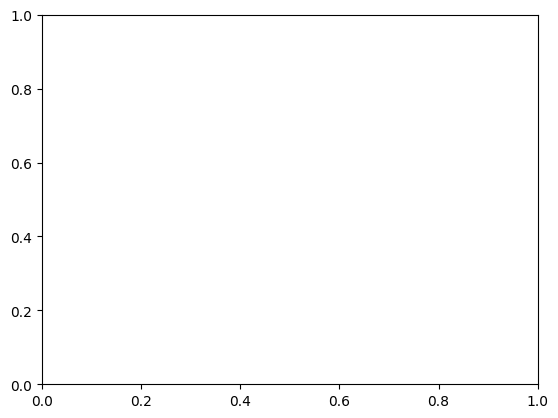

In [92]:
test_loss, test_error, test_gen = evaluation(name=result_dir + name, test_loader=test_loader)
f = open(result_dir + name + '_test_loss.txt', "w")
f.write('NLL: ' + str(test_loss) + '\nCA: ' + str(test_error) + '\nGEN NLL: ' + str(test_gen))
f.close()

samples_real(result_dir + name, test_loader)
samples_generated(result_dir + name, test_loader)

plot_curve(result_dir + name, nll_val)
plot_curve(result_dir + name, error_val, file_name='_ca_val_curve.pdf', color='r-')
plot_curve(result_dir + name, gen_val, file_name='_gen_val_curve.pdf', color='g-')